In [117]:
#pip install mlxtend

In [118]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import statsmodels.api as sm

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Data Load

In [119]:
# Read the cleaned CSV file
fraud_data = pd.read_csv('final_challenge_data_UPDATED.csv')

# Display the first few rows
fraud_data.head()

,fraud_bool,income,name_email_similarity,salary,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,email_domain,name_email_similarity_OutOfRange,prev_address_months_count_missing,current_address_months_count_missing,prev_address_OutOfRange,current_address_OutOfRange,request_OutOfRange,zip_count_4w_missing,zipCount_OutOfRange,velocity6h_OutOfRange,velocity24h_OutOfRange,velocity4w_OutOfRange,bank_branch_count_8w_missing,bankBranchcount_OutOfRange,date_of_birth_distinct_emails_4w_missing,DOBdistinctEmails_OutOfRange,email_is_free_missing,phone_home_valid_missing,phone_mobile_valid_missing,bank_months_count_missing,bankMonths_OutOfRange,has_other_cards_missing,creditLimit_OutOfRange,foreign_request_missing,session_length_in_minutes_missing,sessionLength_OutOfRange,keep_alive_session_missing,deviceDistinctemials_OutOfRange,balconAmount_OutOfRange,device_email_spike_flag,credit_limit_to_salary,total_address_months,address_age_flag
0,0.0,0.3,0.986506,42084.0,-1.0,25.0,43.0,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5.0,5.0,CB,163.0,1.0,BC,0.0,1.0,9.0,0.0,1500.0,0.0,INTERNET,-1.000000,linux,1.0,1.0,0,gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.035643,2.000000,0
1,0.0,0.8,0.617426,105266.0,-1.0,89.0,21.0,0.010095,-0.849551,AD,1658,9223.283431,5745.251481,5941.664859,3.0,18.0,CA,154.0,1.0,BC,1.0,1.0,2.0,0.0,1500.0,0.0,INTERNET,3.363854,other,1.0,1.0,0,yahoo.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.014250,7.333333,0
2,0.0,0.8,0.996707,122830.0,9.0,14.0,43.0,0.012316,-1.490386,AB,1095,4471.472149,5471.988958,5992.555113,15.0,11.0,CA,89.0,1.0,BC,0.0,1.0,30.0,0.0,200.0,0.0,INTERNET,22.730559,windows,0.0,1.0,0,aol.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.001628,1.916667,0
3,0.0,0.6,0.475100,83960.0,11.0,14.0,35.0,0.006991,-1.863101,AB,3483,14431.993621,6755.344479,5970.336831,11.0,13.0,CA,90.0,1.0,BC,0.0,1.0,1.0,0.0,200.0,0.0,INTERNET,15.215816,linux,1.0,1.0,0,aol.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.002382,2.083333,0
4,0.0,0.9,0.842307,146723.0,-1.0,29.0,45.0,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1.0,6.0,CA,91.0,0.0,BC,1.0,1.0,26.0,0.0,200.0,0.0,INTERNET,3.743048,other,0.0,1.0,0,agency.io,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.001363,2.333333,0


In [120]:
fraud_data.shape

(1034372, 65)

In [121]:
#Subsetting missing fraud_bool

missing_bool = fraud_data[fraud_data['fraud_bool'].isna()].copy()
fraud_data = fraud_data.dropna(subset=['fraud_bool'])

In [122]:
fraud_data.shape

(1029672, 65)

In [123]:
missing = fraud_data.isna().sum()/ len(fraud_data)*100
missing

fraud_bool                                  0.000000
income                                      0.443442
name_email_similarity                       0.000000
salary                                      0.444608
prev_address_months_count                   0.000000
current_address_months_count                0.000000
customer_age                                0.000000
days_since_request                          0.000000
intended_balcon_amount                      0.000000
payment_type                                0.000000
zip_count_4w                                0.000000
velocity_6h                                 0.441500
velocity_24h                                0.451406
velocity_4w                                 0.445676
bank_branch_count_8w                        0.000000
date_of_birth_distinct_emails_4w            0.000000
employment_status                           0.000000
credit_risk_score                           0.000000
email_is_free                               0.

In [124]:
print(fraud_data.dtypes)

fraud_bool                                  float64
income                                      float64
name_email_similarity                       float64
salary                                      float64
prev_address_months_count                   float64
current_address_months_count                float64
customer_age                                float64
days_since_request                          float64
intended_balcon_amount                      float64
payment_type                                 object
zip_count_4w                                 object
velocity_6h                                 float64
velocity_24h                                float64
velocity_4w                                 float64
bank_branch_count_8w                        float64
date_of_birth_distinct_emails_4w            float64
employment_status                            object
credit_risk_score                           float64
email_is_free                               float64
housing_stat

In [125]:
int_cols = fraud_data.select_dtypes(include='int').columns
fraud_data[int_cols] = fraud_data[int_cols].astype(float)

In [126]:
print(fraud_data.dtypes)

fraud_bool                                  float64
income                                      float64
name_email_similarity                       float64
salary                                      float64
prev_address_months_count                   float64
current_address_months_count                float64
customer_age                                float64
days_since_request                          float64
intended_balcon_amount                      float64
payment_type                                 object
zip_count_4w                                 object
velocity_6h                                 float64
velocity_24h                                float64
velocity_4w                                 float64
bank_branch_count_8w                        float64
date_of_birth_distinct_emails_4w            float64
employment_status                            object
credit_risk_score                           float64
email_is_free                               float64
housing_stat

In [127]:
fraud_data = fraud_data.drop(['credit_limit_to_salary'],axis=1)

In [128]:
fraud_prop = pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop")/pd.crosstab(index = fraud_data['fraud_bool'], columns = "prop").sum()
print(fraud_prop)

col_0           prop
fraud_bool          
0.0         0.988993
1.0         0.011007


In [129]:
pd.crosstab(index = fraud_data['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,1018338
1.0,11334


## Creating Test/Train & Undersampling

In [130]:
train_o = fraud_data.groupby("fraud_bool").sample(n = 6800, random_state = 6)

test_o = fraud_data.loc[fraud_data.index.difference(train_o.index)]

In [131]:
pd.crosstab(index = train_o['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,6800
1.0,6800


In [132]:
pd.crosstab(index = test_o['fraud_bool'], columns = "count")

col_0,count
fraud_bool,
0.0,1011538
1.0,4534


## Feature Engineering

In [133]:
# Income Column

#Creating a flag column for income 
train_o['income_missing'] = train_o['income'].isna().astype(int)

#filling missing income columns with salary. Have to convert salary to quantiles first
train_o['salary_decile'] = pd.qcut(train_o['salary'], q=10, labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype(float)
train_o['income'] = train_o['income'].fillna(train_o['salary_decile'])
train_o.drop(columns='salary_decile', axis=1, inplace=True)

train_o.drop(columns='salary', axis=1, inplace=True)
train_o = train_o.dropna(subset=['income'])
train_o['income'] = train_o['income'].astype(str)

In [134]:
# zip_count_4w Column 

# Locating rows where 'zip_count_4w' contains a hyphen, flagging, then imputing with -1
bad_zip = train_o['zip_count_4w'].str.contains('-', na=False)
train_o['zip_count_4w_flag'] = bad_zip
train_o.loc[bad_zip, 'zip_count_4w'] = -1
train_o['zip_count_4w'] = train_o['zip_count_4w'].astype(int)

In [135]:
# Velocity Columns 

# Flag missing values
train_o['velocity_6h_missing'] = train_o['velocity_6h'].isna().astype(int)
train_o['velocity_24h_missing'] = train_o['velocity_24h'].isna().astype(int)
train_o['velocity_4w_missing'] = train_o['velocity_4w'].isna().astype(int)

# Impute with median
med_vel_6h = train_o['velocity_6h'].median()
train_o['velocity_6h'] = train_o['velocity_6h'].fillna(med_vel_6h)

med_vel_24h = train_o['velocity_24h'].median()
train_o['velocity_24h'] = train_o['velocity_24h'].fillna(med_vel_24h)

med_vel_4w = train_o['velocity_4w'].median()
train_o['velocity_4w'] = train_o['velocity_4w'].fillna(med_vel_4w)

In [136]:
missing = train_o.isna().sum()/ len(train_o)*100
missing

fraud_bool                                  0.0
income                                      0.0
name_email_similarity                       0.0
prev_address_months_count                   0.0
current_address_months_count                0.0
customer_age                                0.0
days_since_request                          0.0
intended_balcon_amount                      0.0
payment_type                                0.0
zip_count_4w                                0.0
velocity_6h                                 0.0
velocity_24h                                0.0
velocity_4w                                 0.0
bank_branch_count_8w                        0.0
date_of_birth_distinct_emails_4w            0.0
employment_status                           0.0
credit_risk_score                           0.0
email_is_free                               0.0
housing_status                              0.0
phone_home_valid                            0.0
phone_mobile_valid                      

In [137]:
train_o['zip_count_4w_flag'] = train_o['zip_count_4w_flag'].astype('float64')


int_cols = train_o.select_dtypes(include='int').columns
train_o[int_cols] = train_o[int_cols].astype(float)

In [138]:
print(train_o.dtypes)

fraud_bool                                  float64
income                                       object
name_email_similarity                       float64
prev_address_months_count                   float64
current_address_months_count                float64
customer_age                                float64
days_since_request                          float64
intended_balcon_amount                      float64
payment_type                                 object
zip_count_4w                                float64
velocity_6h                                 float64
velocity_24h                                float64
velocity_4w                                 float64
bank_branch_count_8w                        float64
date_of_birth_distinct_emails_4w            float64
employment_status                            object
credit_risk_score                           float64
email_is_free                               float64
housing_status                               object
phone_home_v

In [139]:
predictors = train_o.drop(columns=['fraud_bool'])
predictors = pd.get_dummies(predictors, drop_first=True)
predictors = predictors.astype(float)

X = predictors
y = train_o['fraud_bool']

In [140]:
X.shape

(13600, 114)

### Feature Selection

In [141]:
#Low Variability – Numeric
fraud_data_num = fraud_data.select_dtypes(include = ['number'])
non_flag_cols = [col for col in fraud_data_num.columns if not col.endswith(('_missing', '_OutOfRange', '_flagged'))]

#variance threshold
threshold = 0.01
selector = VarianceThreshold(threshold = threshold)  
selector.fit(fraud_data_num[non_flag_cols])

# Get list of all column names
flag = selector.get_support() 
all_features = fraud_data_num[non_flag_cols].columns 
low_variability_features = all_features[~flag] 
print(low_variability_features.tolist()) 

[]


In [142]:
# Low Variability – Categorical

for col in fraud_data.select_dtypes(include = 'object'): 
    top_freq = fraud_data[col].value_counts(normalize = True).iloc[0] #Loop through each categorical variable, counting each occurance of each unique value 
                                                            
    if top_freq > 0.95: #Categorical variable with 1 category > 95% of the data considered for removal 
        print(f"{col} ({top_freq:.1%})")

source (98.8%)


In [143]:
X = X.drop(['source_TELEAPP'],axis=1)
X = X.drop(['source_UNKNOWN'],axis=1)

In [144]:
# Separate categorical (dummy) vs. continuous features
categorical_features = [col for col in X.columns if X[col].nunique() == 2]
continuous_features = [col for col in X.columns if X[col].nunique() > 2]

X_cat = X[categorical_features]
X_cont = X[continuous_features]

# Fit SelectKBest for categorical variables
selector = SelectKBest(score_func=chi2, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cat, y)

# Correct closing syntax for DataFrame
scores_cat_df = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cat_features = scores_cat_df[scores_cat_df['p_value'] < 0.002]['Feature']

# Sort results for better readability
scores_cat_df = scores_cat_df.sort_values(by='Chi2_score', ascending=False)

# Display top categorical features
print(scores_cat_df)

                                     Feature  Chi2_score        p_value
58                         device_os_windows  876.373674  1.342690e-192
37                                income_0.9  461.329906  2.468775e-102
53                         housing_status_BE  430.360413   1.356577e-95
57                           device_os_other  357.910183   8.028589e-80
51                         housing_status_BC  328.697941   1.846628e-73
20                   device_email_spike_flag  261.060677   1.007664e-58
50                         housing_status_BB  226.613908   3.264496e-51
39                           payment_type_AC  220.145063   8.408948e-50
47                      employment_status_CF  162.691877   2.921026e-37
27                                income_0.1  159.570552   1.404359e-36
44                      employment_status_CC  113.593381   1.599675e-26
43                      employment_status_CB   76.169685   2.603074e-18
45                      employment_status_CD   73.603922   9.547

In [145]:
# Fit SelectKBest for Continous Variables
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' keeps all features for scoring
selector.fit(X_cont, y)

# Create a DataFrame with feature names, F-scores, and p-values
scores_cont_df = pd.DataFrame({
    'Feature': X_cont.columns,
    'F_score': selector.scores_,
    'p_value': selector.pvalues_
})

# Filter for features with p-value < 0.002
selected_cont_features = scores_cont_df[scores_cont_df['p_value'] < 0.002]['Feature']

In [146]:
# Create a new DataFrame with only those selected columns
X_reduced = X[selected_cat_features.tolist() + selected_cont_features.tolist()]

X_reduced.head()

,device_email_spike_flag,income_0.1,income_0.2,income_0.3,income_0.4,income_0.5,income_0.6000000000000001,income_0.9,payment_type_AC,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,housing_status_BB,housing_status_BC,housing_status_BE,housing_status_BF,device_os_macintosh,device_os_other,device_os_windows,email_domain_company.com,email_domain_consulting.co,email_domain_finance.pro,email_domain_gmx.com,email_domain_lawfirm.legal,email_domain_outlook.com,email_domain_startup.biz,email_domain_tech.info,email_domain_work.net,email_domain_yandex.com,email_domain_zoho.com,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,total_address_months
886891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026240,12.0,6.0,35.0,-0.672366,3310.922680,4743.163368,3132.675782,1.0,16.0,61.0,1.0,0.0,1.0,1.0,200.0,0.0,2.845813,0.0,1.0,7.0,1.500000
58076,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111038,-1.0,355.0,54.0,46.327343,8320.107008,3770.638867,4338.994006,1765.0,5.0,59.0,0.0,0.0,1.0,0.0,200.0,0.0,3.183297,1.0,1.0,0.0,29.500000
442457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521989,8.0,0.0,25.0,-0.954958,15575.389326,6361.603856,6618.600641,13.0,11.0,101.0,1.0,0.0,1.0,0.0,200.0,0.0,26.007682,1.0,1.0,3.0,0.666667
594855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.803132,-1.0,133.0,47.0,29.027949,1737.196899,3138.683297,4926.178548,1.0,6.0,205.0,1.0,1.0,1.0,1.0,500.0,0.0,8.492051,1.0,1.0,4.0,11.000000
311331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.998177,-1.0,61.0,51.0,-0.743660,6968.803419,4691.930963,5599.761453,9.0,9.0,68.0,0.0,0.0,1.0,1.0,200.0,0.0,9.771966,0.0,1.0,2.0,5.000000


In [147]:
def check_quasi_complete_separation(X, y):
    """
    Checks each categorical predictor in X for quasi-complete separation with respect to binary target y.
    
    Parameters:
    - X: pd.DataFrame of predictors (categorical variables)
    - y: pd.Series of binary target variable (e.g., 0/1 or True/False)
    
    Returns:
    - List of variable names that exhibit quasi-complete separation
    """
    problematic_vars = []

    for col in X.columns:
        ct = pd.crosstab(X[col], y)

        # Check if any category (row) has a zero in any outcome class
        if (ct == 0).any(axis=1).any():
            print(f"Quasi-complete separation detected in '{col}'")
            print(ct)
            print()
            problematic_vars.append(col)

    return problematic_vars

In [148]:
# Create a new DataFrame with only those selected columns
X_cat_reduced = X_reduced[selected_cat_features.tolist()]

problem_vars = check_quasi_complete_separation(X_cat_reduced, y)

In [149]:
X_reduced = X_reduced.drop(problem_vars, axis = 1)

## Model Building

### Initial Logistic Regression Model

In [150]:
print(train_o.shape)
print(X_reduced.shape)
print(y.shape)

(13600, 68)
(13600, 54)
(13600,)


In [151]:
#Based on undersampling
weight_1 = 1
weight_0 = (1018338/11334) / (6800/6800)

print(weight_0, weight_1)

89.84806776071996 1


In [152]:
train_o['weight'] = train_o.fraud_bool.replace({1: weight_1, 0: weight_0}).astype(float)

X = sm.add_constant(X_reduced)

model_1 = sm.GLM(y, X, family = sm.families.Binomial(), freq_weights = train_o['weight'])
result_1 = model_1.fit()
print(result_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                13600
Model:                            GLM   Df Residuals:                617712.86
Model Family:                Binomial   Df Model:                           53
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29342.
Date:                Fri, 14 Nov 2025   Deviance:                       58684.
Time:                        09:21:10   Pearson chi2:                 6.65e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6954
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

### Stepwise Selection

In [153]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_reduced.columns)

# Model
logr = LogisticRegression(max_iter = 1000, solver = 'newton-cg', penalty = None) 

# Stepwise selection to find best subset of features
sfs = SFS(logr,
          k_features = "best", 
          forward = True,
          floating = True,
          scoring = 'roc_auc',
          cv = 10)

sfs = sfs.fit(X_scaled_df, y)

# Get selected feature names
selected_features = list(sfs.k_feature_names_)
print("Selected features:", selected_features)

Selected features: ['device_email_spike_flag', 'income_0.1', 'income_0.3', 'income_0.9', 'payment_type_AC', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'housing_status_BB', 'housing_status_BC', 'housing_status_BE', 'housing_status_BF', 'device_os_macintosh', 'device_os_other', 'device_os_windows', 'email_domain_company.com', 'email_domain_consulting.co', 'email_domain_gmx.com', 'email_domain_startup.biz', 'email_domain_yandex.com', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'intended_balcon_amount', 'velocity_6h', 'velocity_4w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w']


In [154]:
X_stepwise = X_reduced[selected_features]

In [155]:
train_o['weight'] = train_o.fraud_bool.replace({1: weight_1, 0: weight_0}).astype(float)

X_stepwise = sm.add_constant(X_stepwise).copy()

model_2 = sm.GLM(y, X_stepwise, family = sm.families.Binomial(), freq_weights = train_o['weight'])
result_2 = model_2.fit()
print(result_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             fraud_bool   No. Observations:                13600
Model:                            GLM   Df Residuals:                617725.86
Model Family:                Binomial   Df Model:                           40
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29379.
Date:                Fri, 14 Nov 2025   Deviance:                       58758.
Time:                        09:26:55   Pearson chi2:                 6.51e+05
No. Iterations:                    10   Pseudo R-squ. (CS):             0.6937
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

## Logistic Regression Model Assessment

In [156]:
X_selected = X_stepwise.copy()

### Calibration Curve

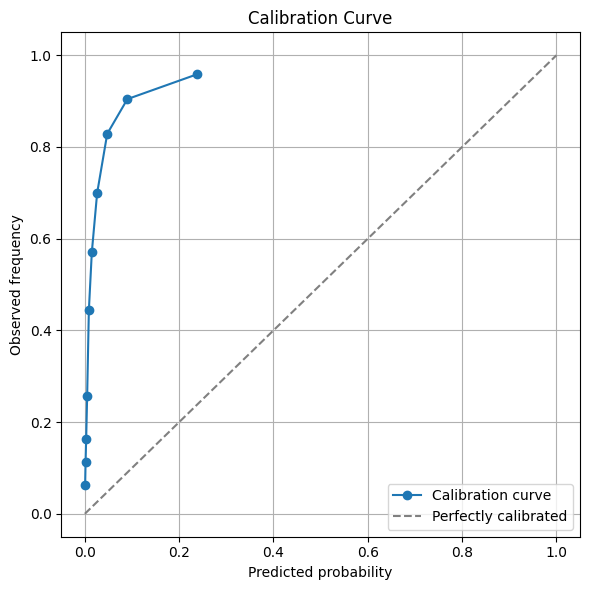

In [157]:
train_o['pred_prob'] = result_2.predict(X_selected)

# Compute calibration curve
prob_true, prob_pred = calibration_curve(train_o['fraud_bool'], train_o['pred_prob'], 
                                         n_bins = 10, strategy = 'quantile')

plt.figure(figsize = (6, 6))
plt.plot(prob_pred, prob_true, marker = 'o', label = 'Calibration curve')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### C-statistic (AUC)

In [158]:
train_o['pred_prob'] = result_2.predict()

auc = roc_auc_score(y, train_o['pred_prob'])
print("C-statistic (AUC):", auc)

C-statistic (AUC): 0.8707246539792387


### Somer's D

In [159]:
somer_d = 2 * auc - 1
print("Somer's D:", somer_d)

Somer's D: 0.7414493079584774


### Classification Table

In [160]:
fpr, tpr, thresholds = roc_curve(train_o['fraud_bool'], train_o['pred_prob'])

data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)

youden.sort_values(by = ['Youden'], ascending = False)

best_threshold = youden.loc[youden['Youden'].idxmax(), 'Cut-off']
print(best_threshold)
print(youden.head())

0.010236049757121531
        TPR       FPR   Cut-off    Youden
0  0.000000  0.000000       inf  0.000000
1  0.000147  0.000000  0.768731  0.000147
2  0.001912  0.000000  0.625734  0.001912
3  0.001912  0.000147  0.616856  0.001765
4  0.006176  0.000147  0.531965  0.006029


In [161]:
train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x > 0.0102360 else 0)

pd.crosstab(train_o['fraud_bool'], train_o['pred'])

pred,0,1
fraud_bool,,
0.0,5317,1483
1.0,1308,5492


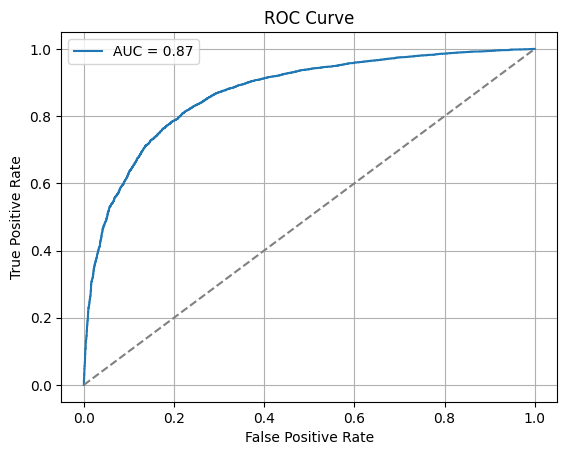

In [162]:
auc = roc_auc_score(train_o['fraud_bool'], train_o['pred_prob'])

plt.cla()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

### K-S Stat

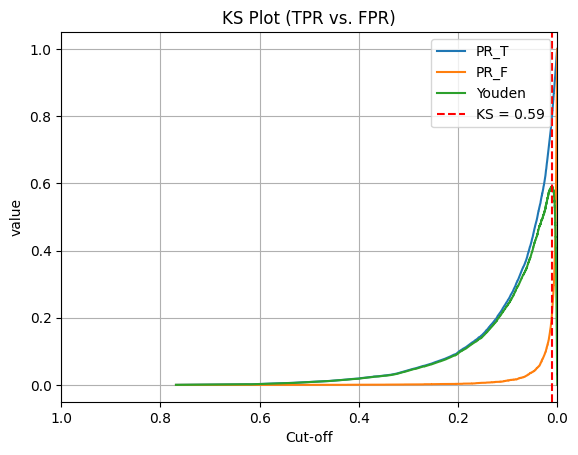

In [163]:
fpr, tpr, thresholds = roc_curve(train_o['fraud_bool'], train_o['pred_prob'])

# Create the Youden DataFrame
youden = pd.DataFrame({
    'Cut-off': thresholds,
    'TPR': tpr,
    'FPR': fpr,
    'Youden': tpr - fpr
})

# Sort by Cut-off and rename
youden = youden.sort_values(by='Cut-off', ascending=True)

ks_stat = youden.rename(columns={'TPR': 'PR_T', 'FPR': 'PR_F'})
ks_stat = ks_stat.melt(id_vars='Cut-off', var_name='PR', value_name='value')

ks_val = (youden['TPR'] - youden['FPR']).max()
ks_cutoff = youden.loc[(youden['TPR'] - youden['FPR']).idxmax(), 'Cut-off']

# Plot
plt.cla()
sns.lineplot(x='Cut-off', y='value', hue='PR', data=ks_stat)
plt.xlim(1, 0)

plt.title("KS Plot (TPR vs. FPR)")
plt.grid(True)
plt.axvline(x=ks_cutoff, linestyle='--', color='red', label=f'KS = {ks_val:.2f}')
plt.legend()
plt.show()

### Taking into account the cost 

In [164]:
# Taking into account the cost 

# True labels and predicted probabilities
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# --- Business Costs ---
C_FN = 1200                     # Cost of false negative (missed fraud)
C_FP_values = np.arange(700, 1001, 100)  # Costs of false positive (700 → 1000)

# --- Check for constant target ---
if len(set(y_true)) < 2:
    raise ValueError("y_true has only one class. Need both positive and negative samples.")

# --- Compute ROC ---
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# --- Base counts ---
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# --- Build results ---
results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# Compute cost for each FP cost level
for C_FP in C_FP_values:
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )

# --- Find best threshold for each FP cost ---
best_thresholds = []
for C_FP in C_FP_values:
    col = f'Cost_FP{C_FP}'
    idx_min = results[col].idxmin()
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': results.loc[idx_min, 'Threshold'],
        'Min_Cost': results.loc[idx_min, col],
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("Optimal thresholds by false positive cost:")
print(best_df)

Optimal thresholds by false positive cost:
   C_FP  Best_Threshold   Min_Cost       TPR       FPR
0   700        0.007077  2472000.0  0.867941  0.292941
1   800        0.007161  2670400.0  0.866471  0.290588
2   900        0.007425  2866800.0  0.861324  0.283529
3  1000        0.009718  3045000.0  0.816176  0.227206


Optimal thresholds and cost savings vs baseline (threshold = 0.5):

   C_FP  Best_Threshold  Baseline_Cost   Min_Cost    Savings   TPR   FPR
0   700            0.01      8107900.0  2472000.0  5635900.0  0.87  0.29
1   800            0.01      8108000.0  2670400.0  5437600.0  0.87  0.29
2   900            0.01      8108100.0  2866800.0  5241300.0  0.86  0.28
3  1000            0.01      8108200.0  3045000.0  5063200.0  0.82  0.23


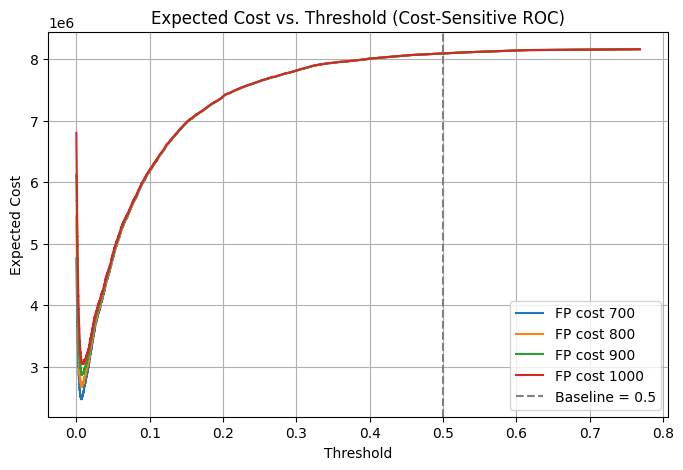

In [165]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# Analyzing Business Costs
C_FN = 1200                        # Cost of missing a fraud
C_FP_values = np.arange(700, 1001, 100)  # Cost range for false positives (700–1000)
baseline_threshold = 0.5           # Your current operational cutoff

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

results = pd.DataFrame({
    'Threshold': thresholds,
    'TPR': tpr,
    'FPR': fpr
})

# Compute cost and baseline savings for each FP cost
best_thresholds = []

# Baseline performance at threshold 0.5
baseline_idx = np.argmin(np.abs(thresholds - baseline_threshold))
baseline_tpr = tpr[baseline_idx]
baseline_fpr = fpr[baseline_idx]

for C_FP in C_FP_values:
    # Expected cost at each threshold
    results[f'Cost_FP{C_FP}'] = (
        (C_FP * results['FPR'] * total_neg) + 
        (C_FN * (1 - results['TPR']) * total_pos)
    )
    
    # Baseline cost
    baseline_cost = (
        (C_FP * baseline_fpr * total_neg) + 
        (C_FN * (1 - baseline_tpr) * total_pos)
    )
    
    # Find minimum cost
    idx_min = results[f'Cost_FP{C_FP}'].idxmin()
    min_cost = results.loc[idx_min, f'Cost_FP{C_FP}']
    best_threshold = results.loc[idx_min, 'Threshold']
    
    # Savings = baseline_cost - min_cost
    savings = baseline_cost - min_cost
    
    best_thresholds.append({
        'C_FP': C_FP,
        'Best_Threshold': best_threshold,
        'Baseline_Cost': baseline_cost,
        'Min_Cost': min_cost,
        'Savings': savings,
        'TPR': results.loc[idx_min, 'TPR'],
        'FPR': results.loc[idx_min, 'FPR']
    })

best_df = pd.DataFrame(best_thresholds)

print("Optimal thresholds and cost savings vs baseline (threshold = 0.5):\n")
print(best_df.round(2))

plt.figure(figsize=(8, 5))
for C_FP in C_FP_values:
    plt.plot(results['Threshold'], results[f'Cost_FP{C_FP}'], label=f'FP cost {C_FP}')
plt.axvline(baseline_threshold, color='gray', linestyle='--', label='Baseline = 0.5')
plt.xlabel('Threshold')
plt.ylabel('Expected Cost')
plt.title('Expected Cost vs. Threshold (Cost-Sensitive ROC)')
plt.legend()  # fixed from plt.lege
plt.grid(True)
plt.show()

Cost-Optimized Threshold (C_FP = 820)
Optimal Threshold : 0.0072
True Positive Rate: 0.8665
False Positive Rate: 0.2906
Minimum Expected Cost: $2,709,920.00


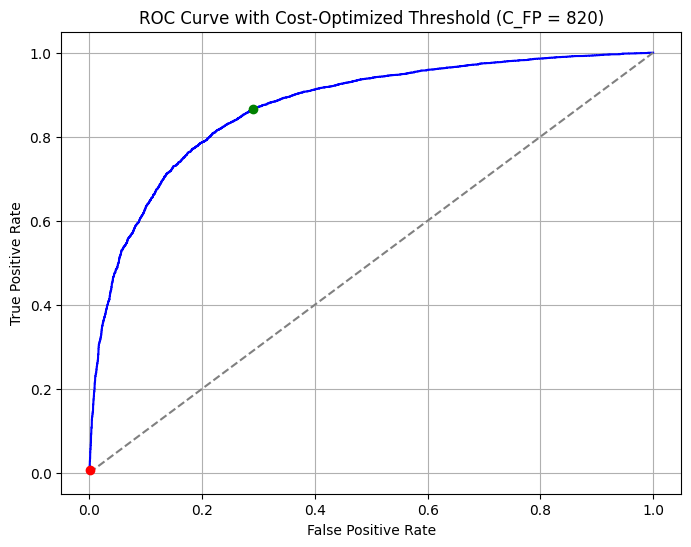

In [166]:
y_true = train_o['fraud_bool'].astype(int)
y_score = train_o['pred_prob'].astype(float)

# ROC curve for standard model (all thresholds)
fpr_model, tpr_model, thresholds_model = roc_curve(y_true, y_score)
auc_model = roc_auc_score(y_true, y_score)

# Analyzing Business cost - setup
C_FN = 1200   # Cost of false negative (missed fraud)
C_FP = 820    # Cost of false positive (wrongly flagged as fraud)

total_pos = sum(y_true)
total_neg = len(y_true) - total_pos

# Computing total business cost for each threshold
costs = (C_FP * fpr_model * total_neg) + (C_FN * (1 - tpr_model) * total_pos)

# Identify optimal threshold minimizing total cost 
idx_min = np.argmin(costs)
optimal_threshold = thresholds_model[idx_min]
optimal_fpr = fpr_model[idx_min]
optimal_tpr = tpr_model[idx_min]
optimal_cost = costs[idx_min]

print("Cost-Optimized Threshold (C_FP = 820)")
print(f"Optimal Threshold : {optimal_threshold:.4f}")
print(f"True Positive Rate: {optimal_tpr:.4f}")
print(f"False Positive Rate: {optimal_fpr:.4f}")
print(f"Minimum Expected Cost: ${optimal_cost:,.2f}")

plt.figure(figsize=(8, 6))

plt.plot(fpr_model, tpr_model, label=f"Model (AUC = {auc_model:.3f})", color='blue')

# Baseline threshold = 0.5 marker
baseline_idx = np.argmin(np.abs(thresholds_model - 0.5))
plt.scatter(
    fpr_model[baseline_idx],
    tpr_model[baseline_idx],
    color='red',
    label=f"Baseline threshold = 0.5",
    zorder=5
)

# Cost-optimized threshold marker
plt.scatter(
    optimal_fpr,
    optimal_tpr,
    color='green',
    label=f"Cost-optimal threshold = {optimal_threshold:.3f} (C_FP = 820)",
    zorder=5
)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Cost-Optimized Threshold (C_FP = 820)")
# plt.legend("cost-Optimized Threshold (C_FP = 820)
# Optimal Threshold : 0.3905
# True Positive Rate: 0.8636
# False Positive Rate: 0.2874
# Minimum Expected Cost: $1,996,740.00")

plt.grid(True)
plt.show()

### Precision, Recall, & Accuracy

In [167]:
precision = np.array([])
recall = np.array([])
accuracy = np.array([])
f1score = np.array([])

for i in range(100):
    train_o['pred'] = train_o['pred_prob'].map(lambda x: 1 if x > i/100 else 0)
    value_p = precision_score(train_o['fraud_bool'], train_o['pred'])
    precision = np.append(precision, value_p)
    value_r = recall_score(train_o['fraud_bool'], train_o['pred'])
    recall = np.append(recall, value_r)
    value_a = accuracy_score(train_o['fraud_bool'], train_o['pred'])
    accuracy = np.append(accuracy, value_a)
    value_f = f1_score(train_o['fraud_bool'], train_o['pred'])
    f1score = np.append(f1score, value_f)

data = {'Precision': precision, 'Recall': recall, 'Accuracy': accuracy, 'Cut-off': range(100), 'F1': f1score}
f1_s = pd.DataFrame(data)

f1_s.sort_values(by = ['F1'], ascending = False)

/deac/opt/rocky9-noarch/python/3.11.8/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/deac/opt/rocky9-noarch/python/3.11.8/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/deac/opt/rocky9-noarch/python/3.11.8/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

,Precision,Recall,Accuracy,Cut-off,F1
1,0.784484,0.810441,0.793897,1,0.797251
2,0.850774,0.670735,0.776544,2,0.750103
3,0.881872,0.570882,0.747206,3,0.693091
0,0.500000,1.000000,0.500000,0,0.666667
4,0.905992,0.500294,0.724191,4,0.644623
5,0.918619,0.438235,0.699706,5,0.593389
6,0.929153,0.385735,0.678162,6,0.545152
7,0.939346,0.346176,0.661912,7,0.505910
8,0.945365,0.310441,0.646250,8,0.467397
9,0.947739,0.277353,0.631029,9,0.429124


In [168]:
def plot_lift_and_gains(y_true, y_proba, n_bins=10):
    """
    Plot Lift and Cumulative Gains curves.
    
    Parameters:
    - y_true: array-like, true binary labels (0/1)
    - y_proba: array-like, predicted probabilities for the positive class
    - n_bins: number of bins/deciles to split data
    
    Returns:
    - None (plots the curves)
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_proba': y_proba
    })
    
    # Sort descending by predicted probability
    df = df.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
    
    # Add cumulative counts
    df['cum_total'] = np.arange(1, len(df) + 1)
    df['cum_positives'] = df['y_true'].cumsum()
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    # Cumulative Gains: % positives captured vs % samples
    df['cum_gains'] = df['cum_positives'] / total_positives
    
    # Lift: (cumulative gains) / (cumulative % of sample)
    df['cum_lift'] = df['cum_gains'] / (df['cum_total'] / total_samples)
    
    # Sample points for plotting (deciles)
    cutoffs = np.linspace(0, total_samples, n_bins + 1, dtype=int)
    cutoffs = cutoffs[cutoffs > 0]  # remove zero
    plot_points = df.loc[cutoffs - 1, ['cum_total', 'cum_gains', 'cum_lift']].copy()
    plot_points['percent_samples'] = plot_points['cum_total'] / total_samples * 100
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Cumulative Gains
    axes[0].plot(plot_points['percent_samples'], plot_points['cum_gains'], marker='o', color='blue', label='Cumulative Gains')
    axes[0].plot([0, 100], [0, 1], linestyle='--', color='blue', alpha=0.5, label='Random Gains')
    axes[0].set_xlabel('Percent of Sample')
    axes[0].set_ylabel('Cumulative Gains')
    axes[0].set_title('Cumulative Gains Curve')
    axes[0].set_ylim(0, 1.05)
    axes[0].grid(True)
    axes[0].legend()
    
    # Plot Lift
    axes[1].plot(plot_points['percent_samples'], plot_points['cum_lift'], marker='o', color='red', label='Lift')
    axes[1].axhline(1, linestyle='--', color='red', alpha=0.5, label='Random Lift')
    axes[1].set_xlabel('Percent of Sample')
    axes[1].set_ylabel('Cumulative Lift')
    axes[1].set_title('Cumulative Lift Curve')
    axes[1].set_ylim(0, plot_points['cum_lift'].max() * 1.1)
    axes[1].grid(True)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

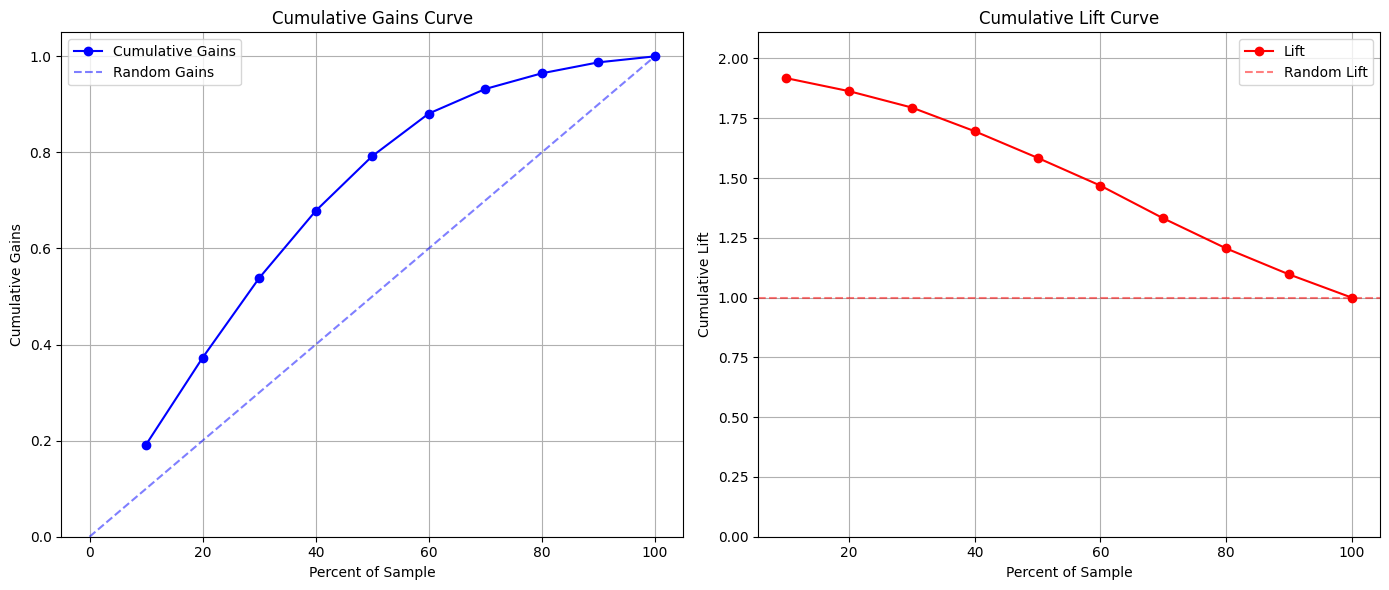

In [169]:
plot_lift_and_gains(train_o['fraud_bool'], train_o['pred_prob'])

### Evaluating Logistic Regression on Test Set

In [170]:
#Feature Engineering 

# Income Column
#Creating a flag column for income 
test_o['income_missing'] = test_o['income'].isna().astype(int)

#filling missing income columns with salary. Have to convert salary to quantiles first
test_o['salary_decile'] = pd.qcut(test_o['salary'], q=10, labels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).astype(float)
test_o['income'] = test_o['income'].fillna(test_o['salary_decile'])
test_o.drop(columns='salary_decile', axis=1, inplace=True)

test_o.drop(columns='salary', axis=1, inplace=True)
test_o = test_o.dropna(subset=['income'])
test_o['income'] = test_o['income'].astype(str)

# zip_count_4w Column 
# Locating rows where 'zip_count_4w' contains a hyphen, flagging, then imputing with -1
bad_zip = test_o['zip_count_4w'].str.contains('-', na=False)
test_o['zip_count_4w_flag'] = bad_zip
test_o.loc[bad_zip, 'zip_count_4w'] = -1
test_o['zip_count_4w'] = test_o['zip_count_4w'].astype(int)

# Velocity Columns 
# Flag missing values
test_o['velocity_6h_missing'] = test_o['velocity_6h'].isna().astype(int)
test_o['velocity_24h_missing'] = test_o['velocity_24h'].isna().astype(int)
test_o['velocity_4w_missing'] = test_o['velocity_4w'].isna().astype(int)

# Impute with median
med_vel_6h = test_o['velocity_6h'].median()
test_o['velocity_6h'] = test_o['velocity_6h'].fillna(med_vel_6h)

med_vel_24h = train_o['velocity_24h'].median()
test_o['velocity_24h'] = test_o['velocity_24h'].fillna(med_vel_24h)

med_vel_4w = test_o['velocity_4w'].median()
test_o['velocity_4w'] = test_o['velocity_4w'].fillna(med_vel_4w)

In [171]:
predictors_test = test_o.drop(columns=['fraud_bool'])
predictors_test = pd.get_dummies(predictors_test, drop_first=True)
predictors_test = predictors_test.astype(float)

X_test = predictors_test
y_test = test_o['fraud_bool']
X_test.head()

,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,name_email_similarity_OutOfRange,prev_address_months_count_missing,current_address_months_count_missing,prev_address_OutOfRange,current_address_OutOfRange,request_OutOfRange,zip_count_4w_missing,zipCount_OutOfRange,velocity6h_OutOfRange,velocity24h_OutOfRange,velocity4w_OutOfRange,bank_branch_count_8w_missing,bankBranchcount_OutOfRange,date_of_birth_distinct_emails_4w_missing,DOBdistinctEmails_OutOfRange,email_is_free_missing,phone_home_valid_missing,phone_mobile_valid_missing,bank_months_count_missing,bankMonths_OutOfRange,has_other_cards_missing,creditLimit_OutOfRange,foreign_request_missing,session_length_in_minutes_missing,sessionLength_OutOfRange,keep_alive_session_missing,deviceDistinctemials_OutOfRange,balconAmount_OutOfRange,device_email_spike_flag,total_address_months,address_age_flag,income_missing,zip_count_4w_flag,velocity_6h_missing,velocity_24h_missing,velocity_4w_missing,income_0.1,income_0.2,income_0.3,income_0.4,income_0.5,income_0.6,income_0.6000000000000001,income_0.7,income_0.7000000000000001,income_0.8,income_0.9,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,payment_type_UNKNOWN,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,employment_status_UNKNOWN,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,housing_status_UNKNOWN,source_TELEAPP,source_UNKNOWN,device_os_macintosh,device_os_other,device_os_windows,device_os_x11,email_domain_aol.com,email_domain_business.org,email_domain_company.com,email_domain_consulting.co,email_domain_finance.pro,email_domain_gmail.com,email_domain_gmx.com,email_domain_hotmail.com,email_domain_icloud.com,email_domain_lawfirm.legal,email_domain_outlook.com,email_domain_protonmail.com,email_domain_startup.biz,email_domain_tech.info,email_domain_unknown,email_domain_work.net,email_domain_yahoo.com,email_domain_yandex.com,email_domain_zoho.com
0,0.986506,-1.0,25.0,43.0,0.006735,102.453711,1059.0,13096.035018,7850.955007,6742.080561,5.0,5.0,163.0,1.0,0.0,1.0,9.0,0.0,1500.0,0.0,-1.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.617426,-1.0,89.0,21.0,0.010095,-0.849551,1658.0,9223.283431,5745.251481,5941.664859,3.0,18.0,154.0,1.0,1.0,1.0,2.0,0.0,1500.0,0.0,3.363854,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.996707,9.0,14.0,43.0,0.012316,-1.490386,1095.0,4471.472149,5471.988958,5992.555113,15.0,11.0,89.0,1.0,0.0,1.0,30.0,0.0,200.0,0.0,22.730559,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.916667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [172]:
# Ensuring test set has same columns as the training set 
train_cols = X_selected.columns
X_test = X_test.reindex(columns=[col for col in X_reduced.columns if col != 'const'])
X_test = sm.add_constant(X_test)
X_test = X_test.reindex(columns=train_cols)

In [173]:
# Predict probabilities using weighted logistic model
y_pred_prob = result_2.predict(X_test)

In [174]:
# Convert probabilities to binary predictions using the best threshold
best_threshold = 0.179717  # replace with your computed optimal threshold
y_pred_binary = (y_pred_prob >= best_threshold).astype(int)

precision = precision_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_prob)
recall = recall_score(y_test, y_pred_binary)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

Best Threshold: 0.18
Precision: 0.1185
Accuracy: 0.9921
F1-Score: 0.1194
AUC: 0.8666
Recall: 0.1202

Confusion Matrix:
 [[1007463    4053]
 [   3989     545]]


## Second Model: Elastic Net

In [175]:
# Standardize all variables
scaler = StandardScaler()
X_reduced_standard = scaler.fit_transform(X_reduced)
X_reduced_standard = pd.DataFrame(X_reduced_standard, 
                                   columns = X_reduced.columns, 
                                   index = X_reduced.index)

# Set up ElasticNetCV with a grid of alphas and l1_ratios
elastic_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 100),
    penalty='elasticnet',
    solver='saga', 
    l1_ratios=[0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 1.0],  # try different L1 ratios
    cv=10,
    random_state=6,
    max_iter=100000,
    scoring='roc_auc'
)

# Fit the model
elastic_cv.fit(X_reduced_standard, y)

,Cs,array([1.0000...00000000e+04])
,fit_intercept,True
,cv,10
,dual,False
,penalty,'elasticnet'
,scoring,'roc_auc'
,solver,'saga'
,tol,0.0001
,max_iter,100000
,class_weight,None
,n_jobs,None


In [178]:
print("Best C (inverse regularization strength):", elastic_cv.C_)
print("Best l1_ratio:", elastic_cv.l1_ratio_)

Best C (inverse regularization strength): [0.02656088]
Best l1_ratio: [0.001]


In [179]:
train_o['pred_prob'] = elastic_cv.predict_proba(X_reduced_standard)[:, 1]

In [180]:
fpr, tpr, thresholds = roc_curve(train_o['fraud_bool'], train_o['pred_prob'])

data = {'TPR': tpr, 'FPR': fpr, 'Cut-off': thresholds, 'Youden': tpr-fpr}
youden = pd.DataFrame(data)

youden.sort_values(by = ['Youden'], ascending = False)

best_threshold = youden.loc[youden['Youden'].idxmax(), 'Cut-off']
print(best_threshold)
print(youden.head())

0.45530868116981726
        TPR       FPR   Cut-off    Youden
0  0.000000  0.000000       inf  0.000000
1  0.000147  0.000000  0.997278  0.000147
2  0.001029  0.000000  0.995961  0.001029
3  0.001029  0.000147  0.995855  0.000882
4  0.004559  0.000147  0.992665  0.004412


In [181]:
# Convert probabilities to binary predictions using the best threshold
best_threshold = 0.455308  # replace with your computed optimal threshold
y_pred_binary = (y_pred_prob >= best_threshold).astype(int)

precision = precision_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_prob)
recall = recall_score(y_test, y_pred_binary)

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

Best Threshold: 0.46
Precision: 0.3158
Accuracy: 0.9955
F1-Score: 0.0230
AUC: 0.8666
Recall: 0.0119

Confusion Matrix:
 [[1011399     117]
 [   4480      54]]
